<a href="https://colab.research.google.com/github/farhanfuadabir/SHL2020/blob/master/SHL_DL_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def createBatch(data, batch_size = 1000, random_state=None):

  """
  Randomly selects `batch_size` entries of each label from the dataset 

  Parameters:

      data          : The dataset to create small batch from. 
                      This must be a DataFrame.
      batch_size    : Batch size of each label
      random_state  : Seed for the random number generator (if int), or numpy 
                      RandomState object.
  
  Returns:

      Series or DataFrame
  """

  y = data.label
  num_label = y.nunique()
  newDataBatch = pd.DataFrame(columns=data.columns)
  
  for i in range(1, num_label + 1):
    data_i = data.loc[y == i, :].sample(n=batch_size, random_state=random_state)
    newDataBatch = pd.concat([newDataBatch, data_i], axis=0)
  return newDataBatch


def random_split_half(data, random_state=123):

  import pandas as pd

  y = data.label
  num_label = y.nunique()
  newDataBatch1 = pd.DataFrame(columns=data.columns)
  
  for i in range(1, num_label + 1):
    data_i = data.loc[y == i, :].sample(frac=0.5, random_state=random_state)
    newDataBatch1 = pd.concat([newDataBatch1, data_i], axis=0)
  newDataBatch2 = pd.concat([data, newDataBatch1], axis=0)
  newDataBatch2 = newDataBatch2.drop_duplicates(keep=False)
  return newDataBatch1, newDataBatch2


def process_train_validation(trainSet, valSet=None, trainBatch=1000,
                             splitValSet=False, random_state=1234, 
                             removeConstantColumn=True, scaleFeatures=True):

  import pandas as pd
  from sklearn.preprocessing import MinMaxScaler

  print('Given Train Set Shape: ', trainSet.shape)
  print('Given Validation Set Shape: ', valSet.shape)

  if trainBatch != None:
    print('\nCreating train batch...', end=' ')
    trainSet = createBatch(trainSet, batch_size=trainBatch, 
                          random_state=random_state)
    print('Done | Shape: ', trainSet.shape)

  if splitValSet == True:
    print('Merging train batch with half validation set...', end=' ')
    valTrain, valSet = random_split_half(valSet, random_state=random_state)
    trainSet = pd.concat([trainSet, valTrain], axis = 0)
    print('Done | Shape: ', trainSet.shape)

  X_train = trainSet.drop('label', axis=1)
  y_train = trainSet.label
  X_val = valSet.drop('label', axis=1)
  y_val = valSet.label

  if removeConstantColumn == True:
    X_temp = X_train
    X_train = X_train.loc[:, (X_temp != X_temp.iloc[0]).any()]
    X_val = X_val.loc[:, (X_temp != X_temp.iloc[0]).any()]
  
  if scaleFeatures == True:
    scaler = MinMaxScaler(feature_range=(-1,1))
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)

  print('\nX_train Shape: ', X_train.shape, ' |  y_train Shape: ', y_train.shape)
  print('X_val Shape: ', X_val.shape, ' |  y_val Shape: ', y_val.shape)

  print('\nInstances of each Label of the Train Set: ')
  print(y_train.value_counts())

  print('\nInstances of each Label of the Validation Set: ')
  print(y_val.value_counts())

  return X_train, y_train, X_val, y_val


In [ ]:
#Import Packages

import pandas as pd
import numpy as np
from joblib import load, dump
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

path = '/content/drive/My Drive/SHL Dataset Fuad/'
combination = 1
trainFile = 'TRAIN_HAND_ALL_ACTIVITY'
valFile = 'VAL_HAND_ALL_ACTIVITY'

#Unpickle Train Set
print('Unpickling from: ' + 'Combination ' + str(combination) + '/' + 
      trainFile + '.joblib ...',end=' ')
data_train = load(path + 'Combination ' + str(combination) + '/' + trainFile + 
                  '.joblib')
print('Done | Shape: ', data_train.shape)

#Unpickle Validation Set
print('Unpickling from: ' + 'Combination ' + str(combination) + '/' + 
      valFile + '.joblib ...',end=' ')
data_val = load(path + 'Combination ' + str(combination) + '/' + valFile + 
                  '.joblib')
print('Done | Shape: ', data_val.shape)


# Check for nan
if data_train.isna().any().any() == True:
  print('\nnan Detected in Train set')
  # Drop nan rows
  print('Dropping nan rows...',end=' ')
  data_train.dropna(inplace=True)
  print('Done | Shape: ', data_train.shape)

if data_val.isna().any().any() == True:
  print('\nnan Detected in Validation set')
  # Drop nan rows
  print('Dropping nan rows...',end=' ')
  data_val.dropna(inplace=True)
  print('Done | Shape: ', data_val.shape)


Using TensorFlow backend.


Unpickling from: Combination 1/TRAIN_HAND_ALL_ACTIVITY.joblib ... Done | Shape:  (126231, 496)
Unpickling from: Combination 1/VAL_HAND_ALL_ACTIVITY.joblib ... Done | Shape:  (28197, 496)


In [ ]:
X_train, y_train, X_test, y_test = process_train_validation(data_train, data_val, 
                                                            trainBatch=1000, 
                                                            splitValSet=False, 
                                                            random_state=1234)

y_train = y_train-1
print('\nLabel of the Train Set: ')
print(y_train.value_counts())

y_test = y_test-1
print('\nLabel of the Validation Set: ')
print(y_test.value_counts())

y_train = to_categorical(y_train,num_classes=8)
y_test = to_categorical(y_test,num_classes=8)

print(y_train.shape,'\n',y_train)

Given Train Set Shape:  (126231, 496)
Given Validation Set Shape:  (28197, 496)

Creating train batch... Done | Shape:  (8000, 496)

X_train Shape:  (8000, 451)  |  y_train Shape:  (8000,)
X_val Shape:  (28197, 451)  |  y_val Shape:  (28197,)

Instances of each Label of the Train Set: 
8.0    1000
7.0    1000
6.0    1000
5.0    1000
4.0    1000
3.0    1000
2.0    1000
1.0    1000
Name: label, dtype: int64

Instances of each Label of the Validation Set: 
1.0    6313
5.0    5143
2.0    4676
7.0    3098
4.0    3082
6.0    2459
8.0    2053
3.0    1373
Name: label, dtype: int64

Label of the Train Set: 
7.0    1000
6.0    1000
5.0    1000
4.0    1000
3.0    1000
2.0    1000
1.0    1000
0.0    1000
Name: label, dtype: int64

Label of the Validation Set: 
0.0    6313
4.0    5143
1.0    4676
6.0    3098
3.0    3082
5.0    2459
7.0    2053
2.0    1373
Name: label, dtype: int64
(8000, 8) 
 [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))


model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(180, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(86, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['categorical_accuracy',f1_m,precision_m, recall_m])

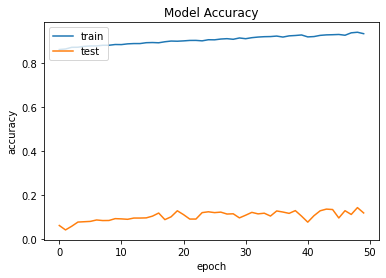

In [ ]:
import matplotlib.pyplot as plt


#history = model.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=500, verbose=1)
# list all data in history
#print(history.history.keys())
# summarize history for accuracy

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
import time

t_start = time.clock()

model.fit(X_train, y_train, epochs=50, batch_size=500)

t_end = time.clock()

print('\n\n\n\n\n')

#_, accuracy_train = model.evaluate(X_train, y_train)
loss_train, accuracy_train, f1_score_train, precision_train, recall_train = model.evaluate(X_train, y_train, verbose=1)
print('Train Accuracy: %.2f' % (accuracy_train*100))
print('Train F1 Score: %.2f' % (f1_score_train*100))
print('Train Time: ', t_end - t_start)

t_start = time.clock()

#_, accuracy_test = model.evaluate(X_test, y_test)
loss_test, accuracy_test, f1_score_test, precision_test, recall_test = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: %.2f' % (accuracy_test*100))
print('Test F1 Score: %.2f' % (f1_score_test*100))

t_end = time.clock()
print('Test Time: ', t_end - t_start)


Epoch 1/50
8000/8000 [==============================] - 1s 69us/step - loss: 0.7455 - categorical_accuracy: 0.7105 - f1_m: 0.6971 - precision_m: 0.8302 - recall_m: 0.6009
Epoch 2/50
8000/8000 [==============================] - 1s 67us/step - loss: 0.7206 - categorical_accuracy: 0.7182 - f1_m: 0.7032 - precision_m: 0.8290 - recall_m: 0.6106
Epoch 3/50
8000/8000 [==============================] - 1s 68us/step - loss: 0.7635 - categorical_accuracy: 0.6999 - f1_m: 0.6867 - precision_m: 0.8219 - recall_m: 0.5901
Epoch 4/50
8000/8000 [==============================] - 1s 69us/step - loss: 0.6992 - categorical_accuracy: 0.7274 - f1_m: 0.7156 - precision_m: 0.8336 - recall_m: 0.6273
Epoch 5/50
8000/8000 [==============================] - 1s 67us/step - loss: 0.7096 - categorical_accuracy: 0.7258 - f1_m: 0.7118 - precision_m: 0.8251 - recall_m: 0.6261
Epoch 6/50
8000/8000 [==============================] - 1s 68us/step - loss: 0.6722 - categorical_accuracy: 0.7404 - f1_m: 0.7317 - precision_m: 

In [ ]:
dump(model, '/content/drive/My Drive/modelDL/model_1.joblib')

['/content/drive/My Drive/modelDL/model_1.joblib']